In [69]:
import pandas as pd
import numpy as np
from scipy.stats import zscore, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import export_graphviz
import graphviz

# decision trees can handle data with little to no preprocessing
# inspiration: https://www.datacamp.com/tutorial/random-forests-classifier-python
# onehot encoding for categorical data: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# example:  https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
# maybe use: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier to get better results

In [92]:
# load data and set options
with open('data/AIDS_Classification_50000.csv') as f:
    # set categorical data types
    df = pd.read_csv(f, dtype={'hemo': 'category', 'homo': 'category', 'drugs': 'category', 'trt': 'category', 'oprior': 'category', 'z30': 'category', 'gender': 'category', 'str2': 'category', 'strat': 'category', 'symptom': 'category', 'treat': 'category', 'offtrt': 'category', 'infected': 'category'})


# drop race column -> us dataset 
df = df.drop(columns='race')

pd.options.display.float_format = '{:.2f}'.format

In [71]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
zscores = df[numeric_cols].apply(zscore)
zscores.describe()

# we ll see if we need a special tretment for high values in cd*, other seems ok

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.64,-3.13,-2.79,-4.09,-0.79,-3.11,-2.47,-1.94,-2.16
25%,-1.09,-0.73,-0.63,-1.34,-0.79,-0.81,-0.77,-0.68,-0.76
50%,0.55,-0.02,-0.15,0.62,-0.48,-0.20,-0.16,-0.33,-0.14
75%,0.84,0.68,0.44,0.62,0.46,0.75,0.64,0.41,0.52
max,1.15,4.77,6.15,0.62,6.23,5.96,4.70,7.39,7.75


In [72]:
df.describe(include='category')

,trt,hemo,homo,drugs,oprior,z30,gender,str2,strat,symptom,treat,offtrt,infected
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,4,2,2,2,2,2,2,2,3,2,2,2,2
top,0,0,1,0,0,1,1,1,1,0,1,0,0
freq,18592,48326,32677,43389,47885,32044,42835,28760,21730,45827,36708,32889,34494


In [94]:
# process a new dataframe
def preprocessing_category(df, col):
    # initalize encoder
    enc = OneHotEncoder(handle_unknown='ignore', feature_name_combiner='concat')

    # transform feature by using encoder    
    new_features_array = enc.fit_transform(df[[col]]).toarray()
    columns = enc.get_feature_names_out()

    # create new dataframe with new features
    enc_df = pd.DataFrame(new_features_array, columns=columns, dtype='category')
    
    # join new features to existing dataframe
    df = df.join(enc_df)
    # drop old feature column
    df = df.drop(columns=col)
    return df

# only preprocess columns with more than 2 values
df = preprocessing_category(df, 'trt')
df = preprocessing_category(df, 'strat')
df.describe(include='category')

{'trt_0': 'category', 'trt_1': 'category', 'trt_2': 'category', 'trt_3': 'category'}
{'strat_1': 'category', 'strat_2': 'category', 'strat_3': 'category'}


,hemo,homo,drugs,oprior,z30,gender,str2,symptom,treat,offtrt,infected,trt_0,trt_1,trt_2,trt_3,strat_1,strat_2,strat_3
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
unique,2,2,2,2,2,2,2,2,2,2,2,2.00,2.00,2.00,2.00,2.00,2.00,2.00
top,0,1,0,0,1,1,1,0,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freq,48326,32677,43389,47885,32044,42835,28760,45827,36708,32889,34494,31408.00,42911.00,39194.00,36487.00,28270.00,40281.00,31449.00


In [74]:
# split data
X = df.drop(columns='infected')
y = df['infected']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [95]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, n_estimators=945)

In [96]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7108


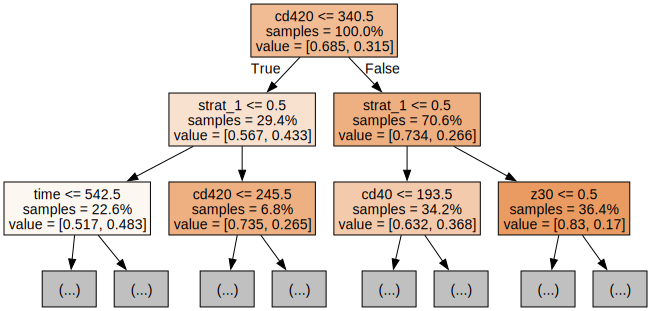

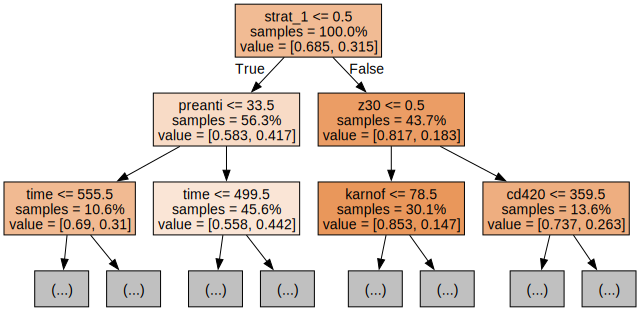

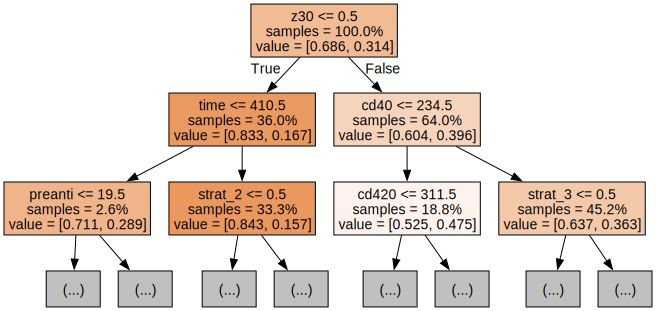

In [77]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [78]:
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(1, 50),
}

print(param_dist)
rf2 = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=30,
                                 cv=5)

rand_search.fit(X_train, y_train)

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x144812ed0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1465751d0>}


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1465751d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x144812ed0>})

In [79]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 18, 'n_estimators': 945}


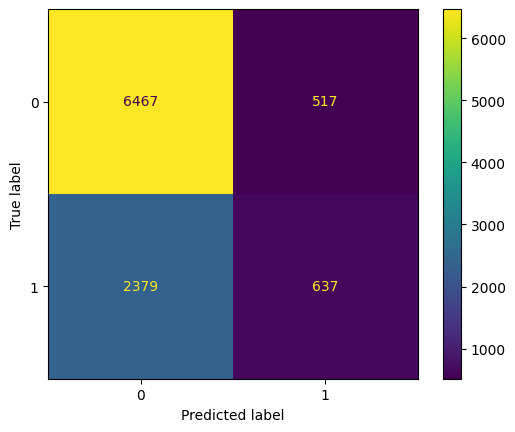

In [80]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [81]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy:", accuracy)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
print("Precision:", precision)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
print("Recall:", recall)

Accuracy: 0.7104
Precision: 0.5519930675909879
Recall: 0.21120689655172414


<Axes: >

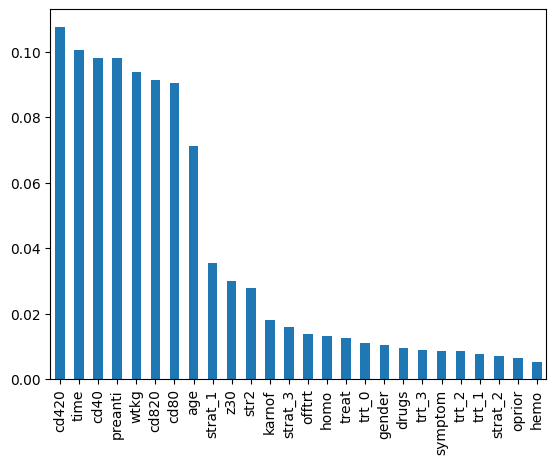

In [82]:
# Create a series containing feature importances from the model and feature names from the training data
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()